# Лабораторная работа №3. Линейные модели для классификации

В задачах классификации, в отличие от задач регрессии, требуется по образу объекта определить его принадлежность к тому или иному классу.
В данной работе будет рассмотрена только задача бинарной (двухклассовой) классификации.
В качестве ответа классификатора используется
$$
P(C_1 | \mathbf\phi) = \sigma( \mathbf{w}^T \mathbf\phi),
$$
где
$$
\sigma(a) = \frac{1}{1 + \mathrm{e}^{-a}}.
$$
 
В случае логистической регрессии минимизируется функция штрафа
$$
E(\mathbf{w}) = -\sum_{n=1}^N\left( t_n \ln y_n + (1 - t_n) \ln (1 - y_n) \right).
$$

Её градиент равен
$$
\nabla E(\mathbf{w}) = \sum_{n=1}^N (y_n - t_n) \mathbf\phi(\mathbf{x}_n) =
\sum_{n=1}^N \left( \sigma(\mathbf{w}^T\mathbf\phi_n - t_n \right) \mathbf\phi_n = \mathbf\Phi^T (\mathbf{y} - \mathbf{T}),
$$
где $\mathbf{y} = (y_1, \dots, y_N)^T$ $-$ отклики распознавателя, $\mathbf{T} = (t_1, \dots, t_N)^T$ $-$ метки классов.
 
Выпишем классический метод градиентного спуска в матричной форме:
$$
\mathbf{w}_{i+1} = \mathbf{w}_i - \alpha\nabla E,\;\;\; i = 1, 2, \dots,
$$
где $\mathbf{w}_0$ задано, а $\nabla E = \nabla E(\mathbf{w}_i, T)$.
Заметим, что здесь $T = \left\{ (\mathbf{x}_k, t_k) \right\}_{k=1}^N$.
То есть в итерационной процедуре на каждой итерации для расчета $\nabla{E}$ используются вся выборка целиком.

Будем теперь вместо полной выборки $T = \left\{ (\mathbf{x}_k, t_k) \right\}_{k=1}^N$ на каждой итерации случайно выбирать $K$ элементов из T:
$T_i = \left( (\mathbf{x}_{i_1}, t_{i_1}), (\mathbf{x}_{i_2}, t_{i_2}), \dots, (\mathbf{x}_{i_K}, t_{i_K}) \right)$.
Назовем $T_i$ пакетом или пачкой (batch).
Индекс $i$ отражает то, что пакет векторов из обучающей выборки выбирается отдельно на каждой итерации.

При $K = 1$ получаем так называемый _стохастический градиентный спуск_ (stochastic gradient descent, SGD).

При $K = N$ используется вся выборка, получаем _классический метод градиентного спуска_ (vanilla gradient descent).

В остальных случаях ($1 < K < N$) метод называют _mini-batch gradient descent_.

На практике обычно _mini-batch gradient descent_ сходится быстрее, чем _vanilla gradient descent_.

Вместе со стохастическим градиентным спуском часто применяют момент.
Момент не позволяет резко измениться направлению спуска.
Это позволяет достичь более плавного и быстрого спуска.
В ряде случаев использование момента также позволяет не «свалиться» в локальный минимум.

**Momentum**.
Итерационный поиск осуществляется по следующему алгоритму:
$$
\begin{gather}
    \mathbf{w}_{i+1} = \mathbf{w}_i + \mathbf{v}_i,\;\;\; i = 1, 2, \dots, \\
    \mathbf{v}_i = \gamma \mathbf{v}_{i-1} - \alpha \nabla{E} \left( \mathbf{w}_i, (\mathbf{x}_{k_i}, t_{k_i} \right), \\
    \mathbf{v}_0 = 0.
\end{gather}
$$

Для параметра $\gamma$ обычно выбирается значение 0.9 или близкое к этому.

In [1]:
import numpy as np
import sklearn as sk
from sklearn import datasets, model_selection, metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
import timeit

mpl.rcParams['axes.grid'] = True

## Задание №1

Разделите выборку на обучающую и тестовую.
Размер тестовой выборки - 20% от размера исходной выборки.
Параметр `n_features` определяется как `3 + mod(<порядковый номер в списке>, 3)`, `n_samples` необходимо взять `600 - 100 * mod(<порядковый номер в списке>, 3)`.
В случае возникновения ошибки, измените параметр `n_informative`.

In [34]:
x, y = sk.datasets.make_classification(n_samples=600 - 100 * np.mod(4, 3), n_features=3 + np.mod(4, 3), random_state=145, n_informative=2, n_redundant=1)
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x, y, test_size=0.2, random_state=25)
print(x_train.shape, y_train.shape)

(400, 4) (400,)


## Задание №2

Реализуйте алгоритм _mini-batch gradient descent_.
В качестве критерия выхода возьмите ограничение по количеству эпох.
Для повторяемости результатов и корректного сравнения алгоритмов, везде используйте одинаковый генераторатор псевдослучайных чисел.

In [29]:
class GradientDescent:
    def __init__(self, batch_size, alpha=1e-3, eps=1e-6, epoch=100):
        self.rng = np.random.default_rng(seed=489);
        self.alpha, self.eps, self.epoch, self.batch_size = alpha, eps, epoch, batch_size
    
    def _update(self, x, derr):
        self.w = self.w - self.alpha * (x.T @ derr)

    def predict_proba(self, x):
        return (1 / (1 + np.exp(- self.w @ x.T))).reshape(-1)

    def fit(self, x, y, val_x, val_y):
        self.w = self.rng.uniform(-1, 1, size=(1, x.shape[1] + 1))        
        self.loss, self.precision = [], []
        self.val_loss, self.val_precision = [], []

        xx = np.concatenate((np.ones((x.shape[0], 1)), x), axis=1)
        yy = np.array(y)

        for i in range(self.epoch):
            idxs = self.rng.permutation(xx.shape[0])
            for idx in range(0, xx.shape[0], self.batch_size):
                batch_idxs = idxs[idx:idx + self.batch_size]
                x_batch, y_batch = xx[batch_idxs], yy[batch_idxs]
                deriv = (self.predict_proba(x_batch) - y_batch)
                self._update(x_batch, deriv)       

            self.loss.append(sk.metrics.log_loss(yy, self(x)))
            self.precision.append(sk.metrics.precision_score(yy, self(x)))
            self.val_loss.append(sk.metrics.log_loss(val_y, self(val_x)))
            self.val_precision.append(sk.metrics.precision_score(val_y, self(val_x)))

    def __call__(self, x):
        xx = np.concatenate((np.ones((x.shape[0], 1)), x), axis=1)
        return (self.predict_proba(xx) >= 0.5).astype(int)

# Тестирование

test_x = np.array([[1, 1, 1], [2, 4, 16], [3, 9, 27]])
gd = GradientDescent(batch_size=10)
gd.fit(test_x, [1, 0, 1], val_x=test_x, val_y=[1, 0, 1])
print("Response", gd(test_x))
assert sk.metrics.precision_score(gd(test_x), [1, 0, 1]) == 1.0, 'Метод недостаточно точный'
assert sk.metrics.accuracy_score(gd(test_x), [1, 0, 1]) > 0.6, 'Метод недостаточно точный'

Response [1 1 1]


## Задание №3

Протестируйте написанный алгоритм, подберите параметры градиентного спуска, дающие после обучения классификатор с наилучшей точностью
($\text{точность} = \frac{\text{количество правильно классифицированных векторов}}{\text{количество векторов}}$).
Сравните классический градиентный спуск, стохастический и mini-batch.
Для начала возьмите следующие параметры:

* случайные начальные значения весов (равномерное распределение на отрезке $[-1; 1]$ для каждой компоненты);
* размер шага обучения $\alpha = 10^{-5}$;
* размер пакета _batch size_ = 20;
* максимальное количество эпох 1000;
* начальные веса должны совпадать.

Приведите в отчет полученную точность и значение функции штрафа на тестовой и обучающей выборках.
Постройте графики для каждого тестируемого размера батча:

* зависимость функции штрафа на обучающей и тестовой выборках от номера эпохи;
* зависимость точности на обучающей и тестовой выборках от номера эпохи;
* зависимость времени выполнения алгоритма от размера батча.

Batch size = 1, precision = 0.9245283018867925
Batch size = 20, precision = 0.9245283018867925
Batch size = 50, precision = 0.9245283018867925
Batch size = 100, precision = 0.9245283018867925
Batch size = 400, precision = 0.9245283018867925
CPU times: total: 28.5 s
Wall time: 28.5 s


Text(0.5, 1.0, 'Зависимость времени работы от размера батча')

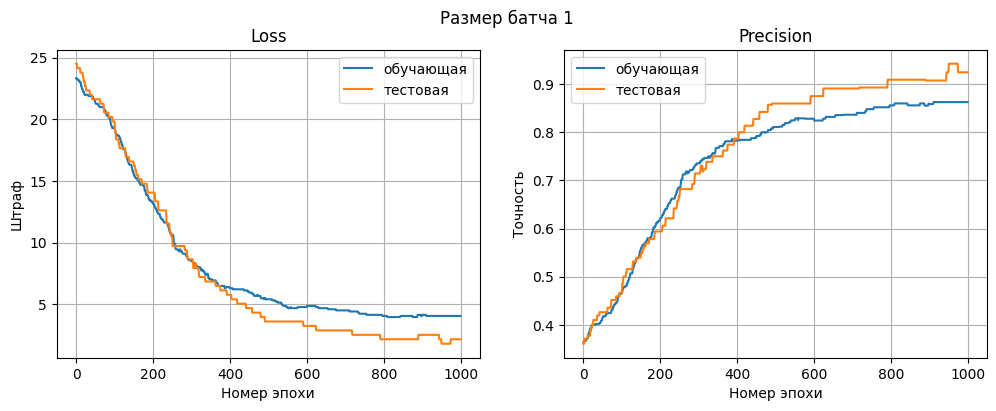

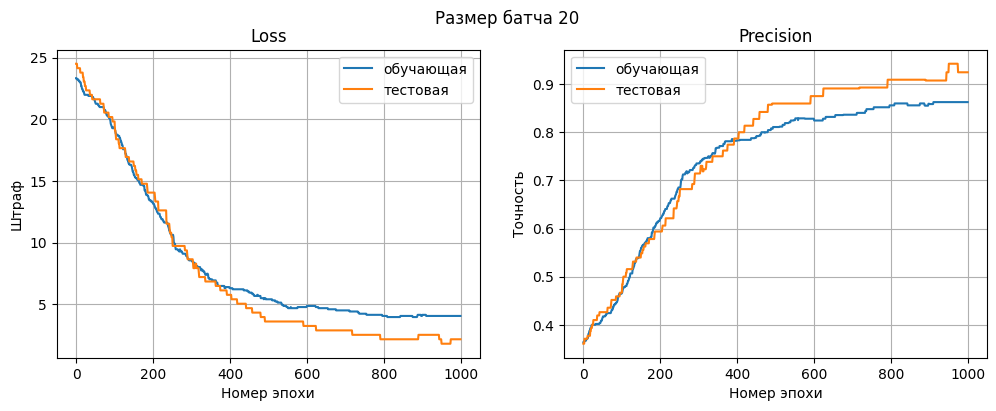

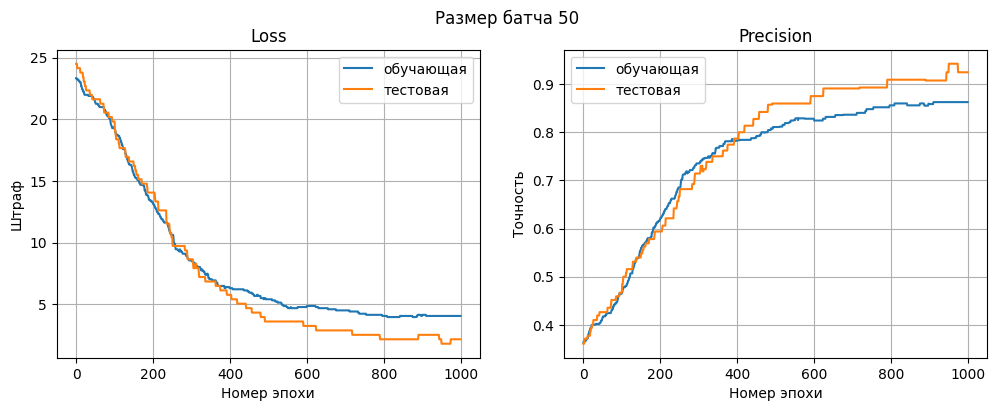

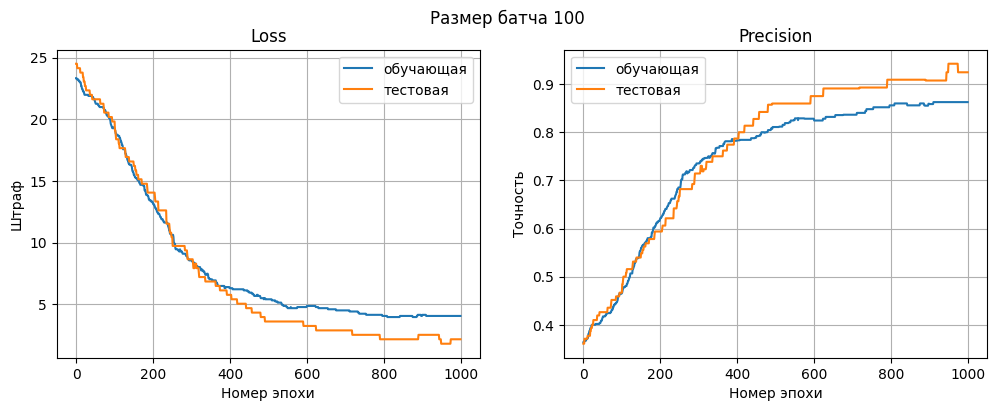

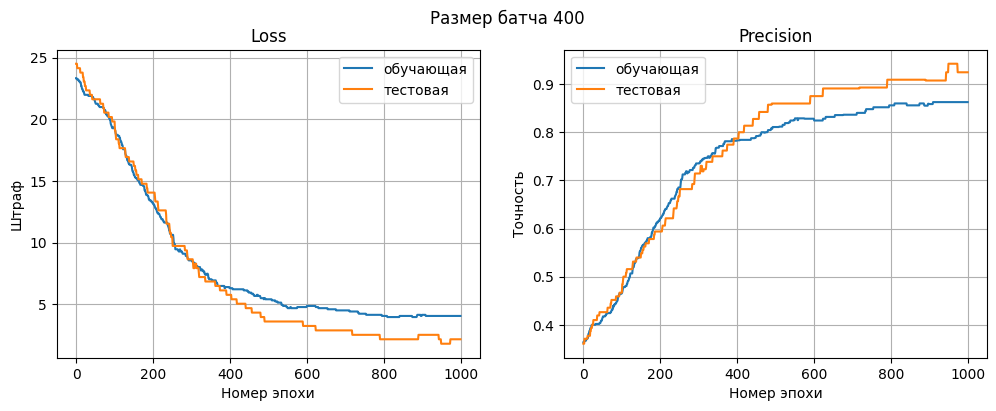

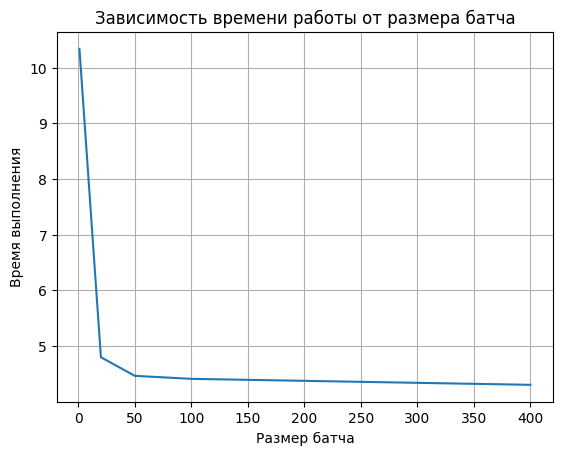

In [38]:
%%time

times = {}
for batch in [1, 20, 50, 100, x_train.shape[0]]:
    gd = GradientDescent(batch, epoch=1000, alpha=1e-5)
    t = timeit.default_timer()
    gd.fit(x_train, y_train, val_x=x_test, val_y=y_test)
    times[batch] = timeit.default_timer() - t
    y_pred = gd(x_test)
    print(f"Batch size = {batch}, precision = {sk.metrics.precision_score(y_test, y_pred)}")
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(2*6, 4))
    ax0.plot(range(len(gd.loss)), gd.loss, label='обучающая')
    ax0.plot(range(len(gd.val_loss)), gd.val_loss, label='тестовая')
    ax0.set(xlabel='Номер эпохи', ylabel='Штраф', title='Loss')
    ax0.legend()
    ax1.plot(range(len(gd.precision)), gd.precision, label='обучающая')
    ax1.plot(range(len(gd.val_precision)), gd.val_precision, label='тестовая')
    ax1.set(xlabel='Номер эпохи', ylabel='Точность', title='Precision')
    ax1.legend()
    fig.suptitle(f"Размер батча {batch}")
    
plt.figure()
plt.plot(times.keys(), times.values()) # python3.7+
plt.xlabel('Размер батча')
plt.ylabel('Время выполнения')
plt.title('Зависимость времени работы от размера батча')

**Вопросы**

1. Зависит ли точность от размера батча? Почему?
1. Зависит ли время работы алгоритма от размера батча? Почему?

**Ответы**

1. В общем случае зависит, так как вариации метода призваны исправить проблему классического метода со скатываем в локальный минимум ценой точности. Судя по графикам в этом конкретном случае подобных пробем не возникает, а потому точность классического метода не выше, чем у мини батчей и стохастического.
2. Обратно пропорциаональная зависисмость от размера батча, вызванное пересчетов вектора w [(общее кол-во векторов) mod (размер батча)] раз.

## Задание №4

Реализуйте метод оптимизации градиентного спуска _momentum_.
Примените наследование от `GradientDescent` и перегрузите метод `_update`, в котором происходят обновления весов модели.

In [36]:
class MomentumGD(GradientDescent):
    def __init__(self, gamma, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.gamma = gamma
        
    def fit(self, x, *args, **kwargs):
        self.v = 0
        super().fit(x, *args, **kwargs)        
    
    def _update(self, x, err):
        self.v = self.gamma * self.v - self.alpha * (x.T @ err)
        self.w += self.v

## Задание №5

Подберите параметры, дающие улучшение сходимости (в большей степени это относится к параметру $\gamma$).  

* Сравните скорость сходимости со скоростью в задании 2.
Для этого постройте графики, на которых сравниваются скорости сходимости и качества модели для **обучающей** выборки.
* Сравните достигнутую точность с точностью в задании 2.
Удалось ли лучше обучить модель?
Чтобы эксперимент был «честным» следует запускать все методы с одними и теми же параметрами и с одними и теми же начальными значениями весов.

Gamma = 0.1, precision = 0.9423076923076923
Gamma = 0.3, precision = 0.9411764705882353
Gamma = 0.6, precision = 0.96
Gamma = 0.9, precision = 0.96
Gamma = 1.0, precision = 0.9607843137254902
CPU times: total: 29.7 s
Wall time: 29.9 s


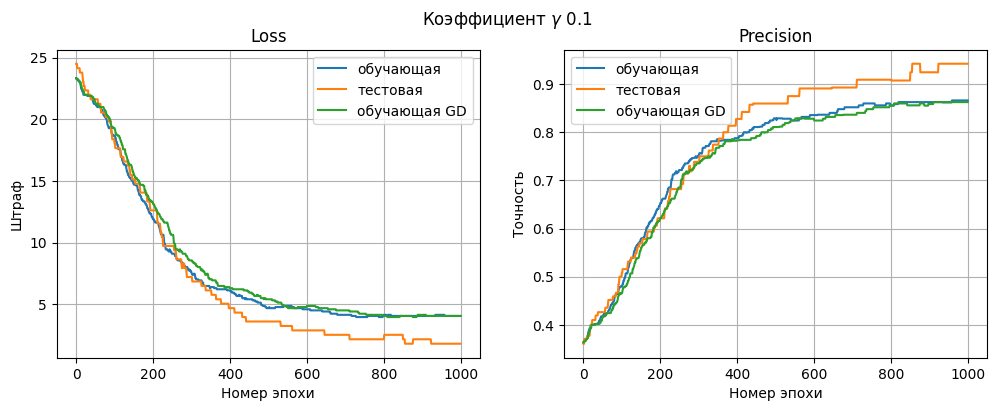

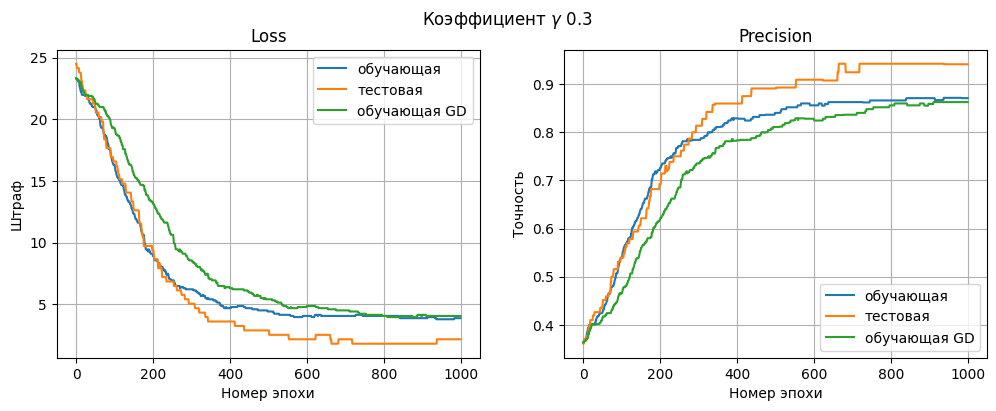

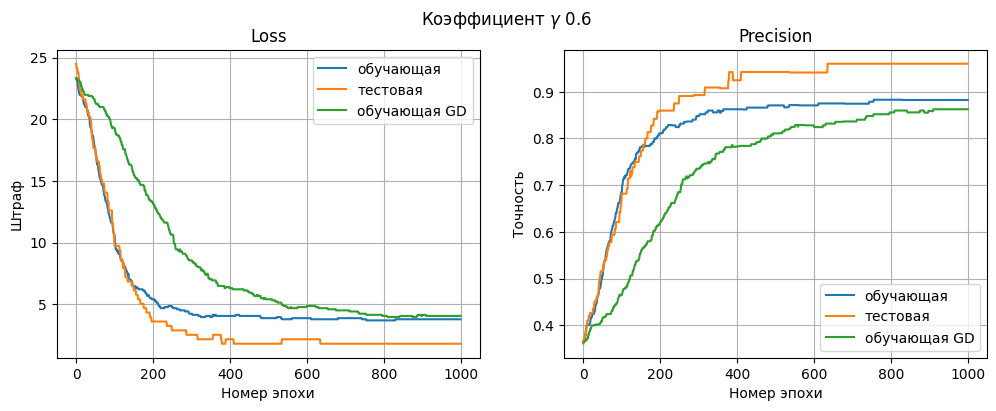

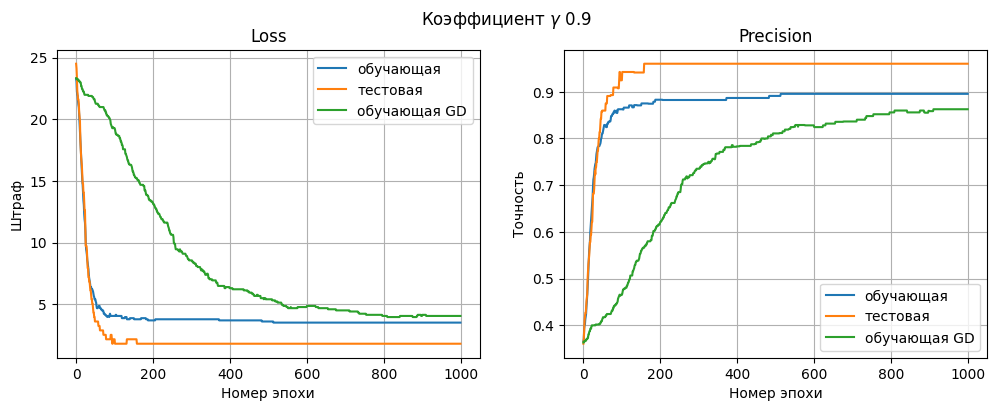

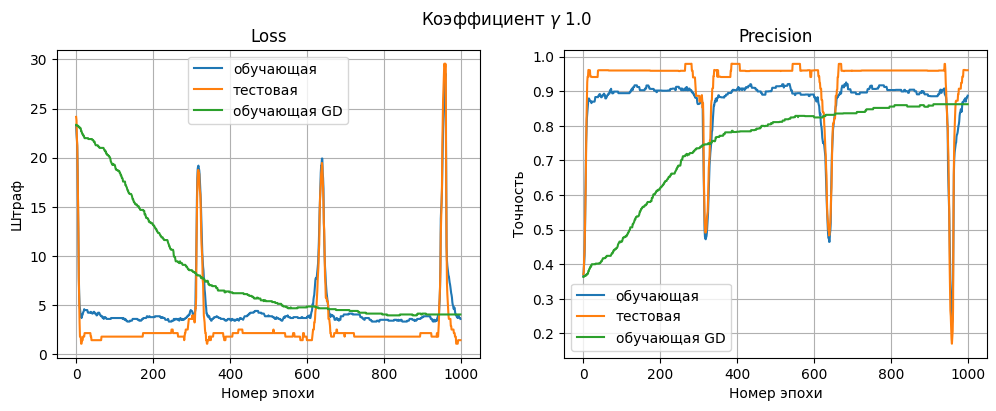

In [39]:
%%time

gd0 = GradientDescent(batch_size=50, epoch=1000, alpha=1e-5)
gd0.fit(x_train, y_train, val_x=x_test, val_y=y_test)

for gamma in [0.1, 0.3, 0.6, 0.9, 1.0]:
    gd = MomentumGD(gamma=gamma, batch_size=50, epoch=1000, alpha=1e-5)
    gd.fit(x_train, y_train, val_x=x_test, val_y=y_test)
    y_pred = gd(x_test)
    print(f"Gamma = {gamma}, precision = {sk.metrics.precision_score(y_test, y_pred)}")

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(2*6, 4))
    
    ax0.plot(range(len(gd.loss)), gd.loss, label='обучающая')
    ax0.plot(range(len(gd.val_loss)), gd.val_loss, label='тестовая')
    ax0.plot(range(len(gd0.loss)), gd0.loss, label='обучающая GD')
    ax0.set(xlabel='Номер эпохи', ylabel='Штраф', title='Loss')
    ax0.legend()

    ax1.plot(range(len(gd.precision)), gd.precision, label='обучающая')
    ax1.plot(range(len(gd.val_precision)), gd.val_precision, label='тестовая')
    ax1.plot(range(len(gd0.precision)), gd0.precision, label='обучающая GD')
    ax1.set(xlabel='Номер эпохи', ylabel='Точность', title='Precision')
    ax1.legend()

    fig.suptitle(f"Коэффициент $\gamma$ {gamma}")

**Вопросы**

1. Какой из алгоритмов быстрее достигает итоговой точности?
1. С ростом коэффициента $\gamma$ алгоритм сходится быстрее или медленее?
1. Что происходит при очень большом коэффициенте $\gamma$?

**Ответы**

1. Оптимизированный метод с использованием момента.
2. Сходится быстрее до достижения оптимального занияения.
3. Метод становится неустойчивым.

## Задание №6

Для какой-либо из обученных моделей постройте график, на котором изображено разделение пространства признаков на две области.
Проверьте, что разделяющая поверхность - линейная.

Text(0, 0.5, 'X1')

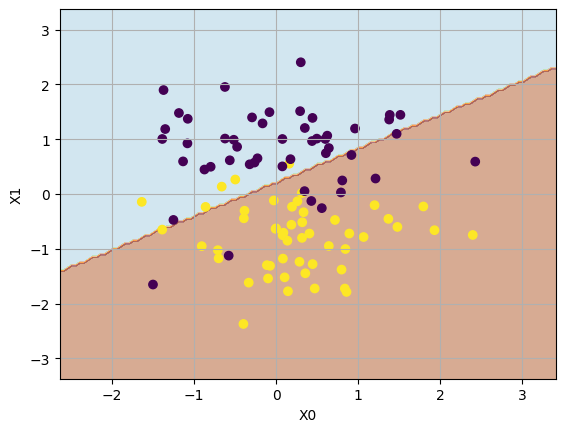

In [41]:
x_min, x_max = x_test[:, 0].min() - 1, x_test[:, 0].max() + 1
y_min, y_max = x_test[:, 1].min() - 1, x_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))
Z = gd0(np.c_[xx.ravel(), yy.ravel(), np.zeros((xx.ravel().shape[0], x_test.shape[1] - 2))])
plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.Paired, alpha=0.5)

plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test)
plt.xlabel('X0')
plt.ylabel('X1')

## Задание №7

Классы в выборке не являются линейно разделимыми.
С данной проблемой можно бороться, воздействуя какой-то функцией на старые признаки:
$$
\mathbf{\phi}(\mathbf{x}) = \left( \phi_1(x_1, \dots, x_n), \dots, \phi_n(x_1, \dots, x_n) \right)^T.
$$

Покажите, как изменяется разделяющая поверхность, если задавать разную функцию отображения.
Постройте график, на котором изображено разделение пространства признаков и приведите величину достигнутой точности на тестовой выборке.
Попробуйте добиться лучшей точности (необязательно).

C:\Users\1\AppData\Local\Temp\ipykernel_18360\2688904149.py:10: RuntimeWarning: overflow encountered in exp
  return (1 / (1 + np.exp(- self.w @ x.T))).reshape(-1)
C:\Users\1\AppData\Local\Temp\ipykernel_18360\2688904149.py:10: RuntimeWarning: overflow encountered in exp
  return (1 / (1 + np.exp(- self.w @ x.T))).reshape(-1)
C:\Users\1\AppData\Local\Temp\ipykernel_18360\2688904149.py:10: RuntimeWarning: overflow encountered in exp
  return (1 / (1 + np.exp(- self.w @ x.T))).reshape(-1)
C:\Users\1\AppData\Local\Temp\ipykernel_18360\2688904149.py:10: RuntimeWarning: overflow encountered in exp
  return (1 / (1 + np.exp(- self.w @ x.T))).reshape(-1)
C:\Users\1\AppData\Local\Temp\ipykernel_18360\2688904149.py:10: RuntimeWarning: overflow encountered in exp
  return (1 / (1 + np.exp(- self.w @ x.T))).reshape(-1)
C:\Users\1\AppData\Local\Temp\ipykernel_18360\2688904149.py:10: RuntimeWarning: overflow encountered in exp
  return (1 / (1 + np.exp(- self.w @ x.T))).reshape(-1)
C:\Users\1\AppDa

Score = 0.9411764705882353
CPU times: total: 5.09 s
Wall time: 5.16 s


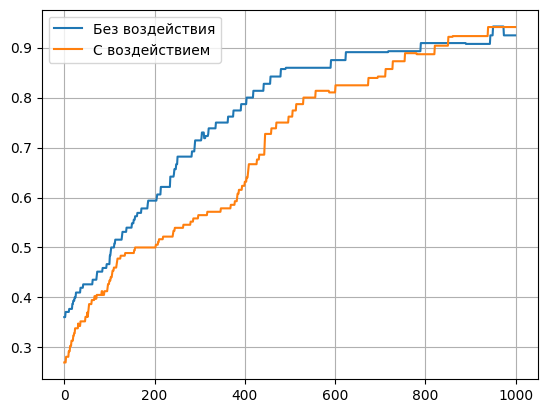

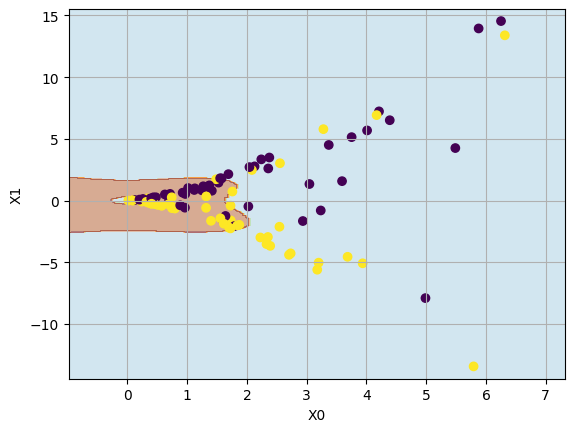

In [45]:
%%time

class MGD(GradientDescent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def _func(self, x):
       xx = 0.01*np.concatenate([(x[:, 0].reshape(-1,1))**(p+1)+(x[:, 1].reshape(-1,1))**(p+1) for p in range(1, x.shape[1])], axis=1)
       return np.concatenate((xx, x[:,2].reshape(-1,1)), axis=1)
    
    def fit(self, x, y, val_x, val_y):
        super().fit(self._func(x), y, val_x, val_y)
    
    def __call__(self, x):
        return super().__call__(self._func(x))

gdx = MGD(batch_size=50, epoch=1000, alpha=1e-5)
gdx.fit(x_train, y_train, x_test, y_test)
plt.plot(range(len(gd0.val_precision)), gd0.val_precision, label='Без воздействия')
plt.plot(range(len(gdx.val_precision)), gdx.val_precision, label='С воздействием')
plt.legend()

plt.figure()
x_min, x_max = gdx._func(x_test)[:, 0].min() - 1, gdx._func(x_test)[:, 0].max() + 1
y_min, y_max = gdx._func(x_test)[:, 1].min() - 1, gdx._func(x_test)[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

Z = gdx(np.c_[xx.ravel(), yy.ravel(), np.zeros((xx.ravel().shape[0], x_test.shape[1] - 2))])

plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.Paired, alpha=0.5)

plt.scatter(gdx._func(x_test)[:, 0], gdx._func(x_test)[:, 1], c=y_test)
plt.xlabel('X0')
plt.ylabel('X1')

print("Score =", sk.metrics.precision_score(y_test, gdx(x_test)))

**Выводы**:

...